In [11]:
# This allows matplotlib plots to be shown inline
%matplotlib inline

import ROOT as r
import rootnotes
import numpy as np
import matplotlib.pyplot as plt

canvas = rootnotes.default_canvas()

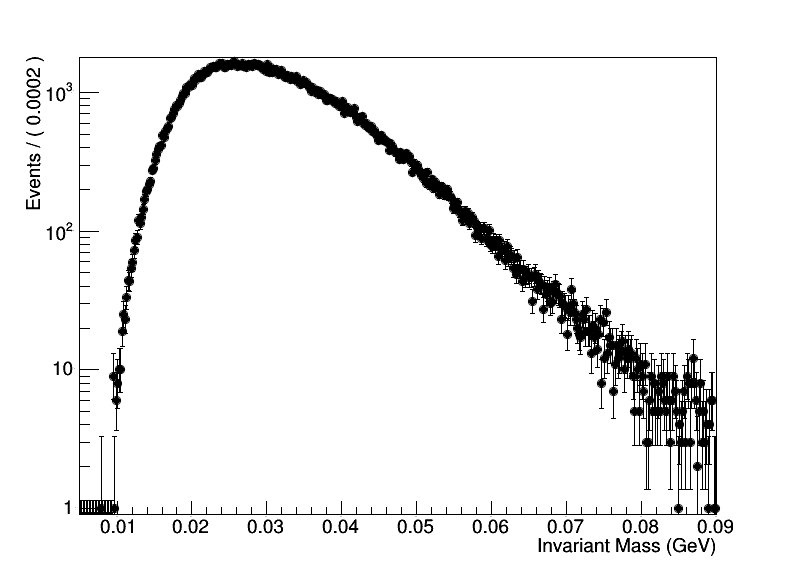

In [17]:
# Path to ROOT file that will be used to obtain the Trident invariant mass histogram
file_path = "/home/omoreno/work/hps/plots/engrun2015/pass3/1pt05_mc/tridents/rad/trident_analysis.root"

# Open the ROOT file and get the Trident invariant mass histogram
root_file = r.TFile(file_path)

# Create a data histogram that is compatible with RooFit
invariant_mass = r.RooRealVar("Invariant Mass", "Invariant Mass (GeV)", 0.005, 0.09)
arg_list = r.RooArgList(invariant_mass)
histogram_data = r.RooDataHist("invariant_mass_data", "invariant_mass_data", arg_list, root_file.Get("invariant mass"))

# Get the frame that will be used in plotting
plot = invariant_mass.frame()

# Plot the histogram data
histogram_data.plotOn(plot)

# Draw the frame 
plot.Draw()
plot.SetTitle("")
canvas.SetLogy()
canvas

# Composite Model


In [55]:
# The mean of the signal must be set and can't vary
ap_mass_mean = r.RooRealVar("ap_mass_mean", "ap_mass_mean", .003)
ap_mass_mean.setConstant(r.kTRUE)

# For now, assume a constant mass resolution across our range
ap_mass_sigma = r.RooRealVar("ap_mass_sigma", "ap_mass_sigma", 0.0025)
ap_mass_sigma.setConstant(r.kTRUE)

# Create a gaussian signal pdf with the mean at the mass hypothesis and sigma
# set to the mass resolution
signal = r.RooGaussian("signal", "signal", invariant_mass, ap_mass_mean, ap_mass_sigma)

# Variables used to define polynomials
a = []

a.append(r.RooRealVar("a0", "a0", -1, -250, 0))
a.append(r.RooRealVar("a1", "a1", 0, -100, 100))
a.append(r.RooRealVar("a2", "a2", 0, -100, 100))
a.append(r.RooRealVar("a3", "a3", 0, -100, 100))
a.append(r.RooRealVar("a4", "a4", 0, -100, 100))
a.append(r.RooRealVar("a5", "a5", 0, -100, 100))
a.append(r.RooRealVar("a6", "a6", 0, -100, 100))

nsig = r.RooRealVar("nsig","signal fraction", 0,-10.,100000.)
nbkg = r.RooRealVar("nbkg","background fraction", 500., 0.,10000000.) 

bkg_models = []
models = []

arg_list = r.RooArgList()
for var_index in range(0, len(a)) : 
    arg_list.add(a[var_index])
    print "Creating polynomial model of order " + str(var_index)
    bkg_models.append(r.RooChebychev("bkg_" + str(var_index), 
                                     "bkg_" + str(var_index), 
                                     invariant_mass, 
                                     arg_list)) 
    
    models.append(r.RooAddPdf("model_" + str(var_index), 
                              "model_" + str(var_index), 
                               r.RooArgList(signal, bkg_models[var_index]), 
                               r.RooArgList(nsig, nbkg)))
    

Creating polynomial model of order 0
Creating polynomial model of order 1
Creating polynomial model of order 2
Creating polynomial model of order 3
Creating polynomial model of order 4
Creating polynomial model of order 5
Creating polynomial model of order 6


# Fitting multiple polynomials within a window

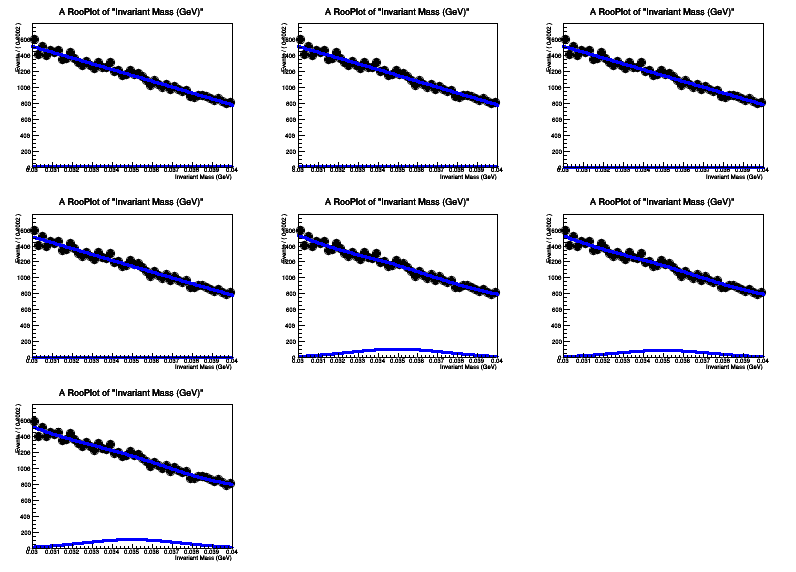

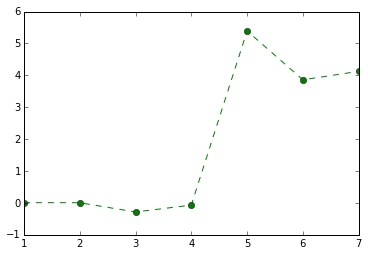

In [58]:
invariant_mass.setRange("test_range", 0.03, 0.04)
ap_mass_mean.setVal(0.035)

canvas.Clear()
canvas.Divide(3,3)

canvas.cd(1)

s = []
s_error = []
poly_values = []

index = 1

for model in models :
    plot = invariant_mass.frame(r.RooFit.Range("test_range"))
    model.fitTo(histogram_data, r.RooFit.Range("test_range"), r.RooFit.Extended())
    histogram_data.plotOn(plot, r.RooFit.Range("test_range"))
    model.plotOn(plot, r.RooFit.NormRange("test_range"))
    model.plotOn(plot, r.RooFit.Components("signal"), r.RooFit.NormRange("test_range"), 
                 r.RooFit.LineStyle(r.RooFit.kDashed))
    params = model.getVariables()
    s.append(params.find("nsig").getVal())
    s_error.append(params.find("nsig").getError())
    poly_values.append(index)
    canvas.cd(index)
    plot.Draw()
    index += 1

s_pull = np.divide(np.array(s), np.array(s_error))
plt.plot(poly_values, s_pull,'g--o')
    
canvas

# Fitting Using the Model

Fitting in window [ 0.03, 0.05 ]
Setting A' mass hypothesis to 0.04 GeV
Fitting in window [ 0.0305, 0.0505 ]
Setting A' mass hypothesis to 0.0405 GeV
Fitting in window [ 0.031, 0.051 ]
Setting A' mass hypothesis to 0.041 GeV
Fitting in window [ 0.0315, 0.0515 ]
Setting A' mass hypothesis to 0.0415 GeV
Fitting in window [ 0.032, 0.052 ]
Setting A' mass hypothesis to 0.042 GeV
Fitting in window [ 0.0325, 0.0525 ]
Setting A' mass hypothesis to 0.0425 GeV
Fitting in window [ 0.033, 0.053 ]
Setting A' mass hypothesis to 0.043 GeV
Fitting in window [ 0.0335, 0.0535 ]
Setting A' mass hypothesis to 0.0435 GeV
Fitting in window [ 0.034, 0.054 ]
Setting A' mass hypothesis to 0.044 GeV
Fitting in window [ 0.0345, 0.0545 ]
Setting A' mass hypothesis to 0.0445 GeV


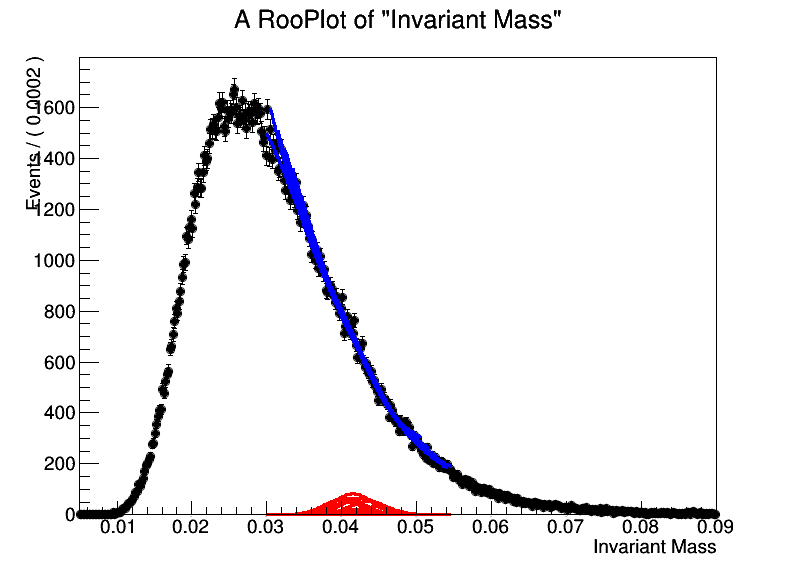

In [6]:
mass_window_size = 0.02
mass_window_step = 0.0005
mass_window_start = 0.03

plot = invariant_mass.frame()
histogram_data.plotOn(plot)

s = []
s_error = []
mass = []

while mass_window_start < 0.055 - mass_window_size : 
    print "Fitting in window [ " + str(mass_window_start) + ", " + str(mass_window_start + mass_window_size) + " ]"
    ap_mass = mass_window_start + mass_window_size/2
    invariant_mass.setRange("A' mass = " + str(ap_mass), mass_window_start, mass_window_start + mass_window_size)
    print "Setting A' mass hypothesis to " + str(ap_mass) + " GeV"
    ap_mass_mean.setVal(ap_mass)
    mass.append(ap_mass)
    models[6].fitTo(histogram_data, r.RooFit.Range("A' mass = " + str(ap_mass)), r.RooFit.Extended())
    models[6].plotOn(plot, r.RooFit.Range("A' mass = " + str(ap_mass)), r.RooFit.NormRange("A' mass = " + str(ap_mass)))
    models[6].plotOn(plot, r.RooFit.Range("A' mass = " + str(ap_mass)), r.RooFit.Components("signal"), r.RooFit.LineStyle(r.RooFit.kDashed), 
                r.RooFit.NormRange("A' mass = " + str(ap_mass)), r.RooFit.LineColor(r.RooFit.kRed))
    params = models[6].getVariables()
    s.append(params.find("nsig").getVal())
    s_error.append(params.find("nsig").getError())
    mass_window_start += mass_window_step

plot.Draw()
canvas

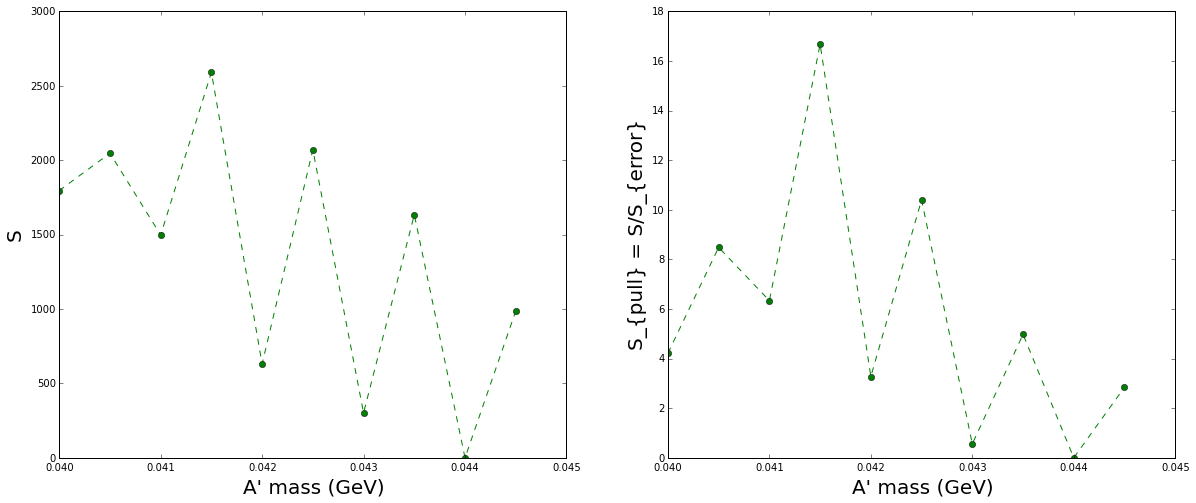

In [7]:
s_pull = np.divide(np.array(s), np.array(s_error))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 8))

ax0.plot(mass, s, 'g--o')
ax0.set_xlabel("A' mass (GeV)", fontsize=20)
ax0.set_ylabel("S", fontsize=20)
ax1.plot(mass, s_pull, 'g--o')
ax1.set_xlabel("A' mass (GeV)", fontsize=20)
ax1.set_ylabel("S_{pull} = S/S_{error}", fontsize=20)